# Siamese Network for Tree Crown Species Classifcation

This notebook trains a siamese network with ideas derived from [face recognition](https://medium.com/wicds/face-recognition-using-siamese-networks-84d6f2e54ea4) in order to classify tree crowns to different species of interest. This work is motivated by the need for a few shot learning model to detect tree species due to limited availability of data-sets.

In [1]:
# Import libraries
import keras
import tensorflow as tf
from keras import backend as k
import numpy as np
import matplotlib.pyplot as plt
from classification_models.keras import Classifiers

2023-09-07 12:49:25.231065: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-07 12:49:25.253461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model Implementation

In [2]:
# Set Keras backend for image data format

keras.backend.set_image_data_format('channels_first')

### Create the base model that extracts features from the input images
Both input images that are to be compared are run through the same network to provide embeddings whose similarity will be compared

In [3]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18(input_shape=(3,100,100), weights='imagenet', include_top=False)
base_model.trainable = False

def create_model():
    # Inputs
    inputs = keras.Input(shape=(3, 100, 100))

    # Run input image through our base model (ResNet)
    x = base_model(inputs, training = False)

    # Convert features from base model to a vector
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    # Create output layer
    outputs = keras.layers.Dense(32)(x)

    model = keras.Model(inputs, outputs)
    return model

### Extract features from the base network

In [4]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

In [5]:
def siamese_model():
    feature_extractor_model = create_model()
    imgA = keras.Input(shape=(3, 100, 100))
    imgB = keras.Input(shape=(3, 100, 100))
    featA = feature_extractor_model(imgA)
    featB = feature_extractor_model(imgB)
    distance = keras.layers.Lambda(euclidean_distance)([featA, featB])
    outputs = keras.layers.Dense(1, activation="sigmoid")(distance)
    model = keras.Model(inputs=[imgA, imgB], outputs=outputs)
    return model

In [22]:
model = siamese_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 3, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 model_3 (Functional)           (None, 32)           11203305    ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

In [29]:
opt = keras.optimizers.Adam(learning_rate=0.01)
loss = keras.losses.BinaryCrossentropy()
metrics = [keras.metrics.BinaryAccuracy(threshold=0.5)]
model.compile(loss=loss, optimizer=opt, metrics=metrics)

# Data Preparation

Read the IDTreeS Dataset and cut-out individual tree crowns

In [8]:
import glob

from rioxarray.exceptions import NoDataInBounds
from sklearn.preprocessing import LabelEncoder 
import IDTreeS_dataset

# Data Loader from IDTreeS Dataset
rgb_paths = glob.glob('../train/RemoteSensing/RGB/*.tif')
bboxes_paths = glob.glob('../train/ITC/train_*.shp')
classes_path = '../train/Field/train_data.csv'

In [9]:
# Convert generator dataset in to suitable input for keras
ds = IDTreeS_dataset.IDTreeSDataset(rgb_paths, bboxes_paths, classes_path, augment_data=False)

ids, Y, X = ds.get_cutouts()

nclasses = len(np.unique(Y)) #Number of classes in training data

Preprocess data to suit ResNET

In [10]:
def preprocess_data(X):
    X_p = preprocess_input(X)
    # Y_p = keras.utils.to_categorical(Y, nclasses)
    return X_p

X = preprocess_data(X)

Create positive and negative image pairs from the dataset:

- Images for each label are limited to 10 samples.
- Labels 0-5 (6 classes) are used to train the siamese network
- Labels 6-8 (3 classes) will be used to test the trained network


In [11]:
unique_labels = np.unique(Y)
label_wise_indices = dict()
label_wise_samples = dict()
for label in unique_labels:
    label_wise_indices.setdefault(label,
                                    [index for index, curr_label in enumerate(Y) if
                                    label == curr_label])

In [12]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    label_wise_samples = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    samples = {key: len(value) for key, value in label_wise_indices.items()}
    for i in range(len(label_wise_indices)):
        label_wise_samples[i] = label_wise_indices[i][0:min(samples.values())] 

    pair_images = []
    pair_labels = []
    pair_index = []
    for index, image in enumerate(images_dataset):
        if index in np.ndarray.flatten(np.array(([*label_wise_samples.values()]))):
            pos_indices = label_wise_samples.get(labels_dataset[index])
            pos_index = np.random.choice(pos_indices)
            pos_image = images_dataset[pos_index]
            pair_images.append((image, pos_image))
            pair_labels.append(1)
            pair_index.append((index,pos_index))

            neg_indices = np.setdiff1d(np.ndarray.flatten(np.array(([*label_wise_samples.values()]))), pos_indices)
            neg_index = np.random.choice(neg_indices)
            neg_image = images_dataset[neg_index]
            pair_images.append((image, neg_image))
            pair_index.append((index,neg_index))
            pair_labels.append(0)
        else:
            continue
    return np.array(pair_images), np.array(pair_labels), np.array(pair_index)

In [13]:
images_pair, labels_pair, index_pair = generate_train_image_pairs(X, Y)
images_pair.shape

(252, 2, 3, 100, 100)

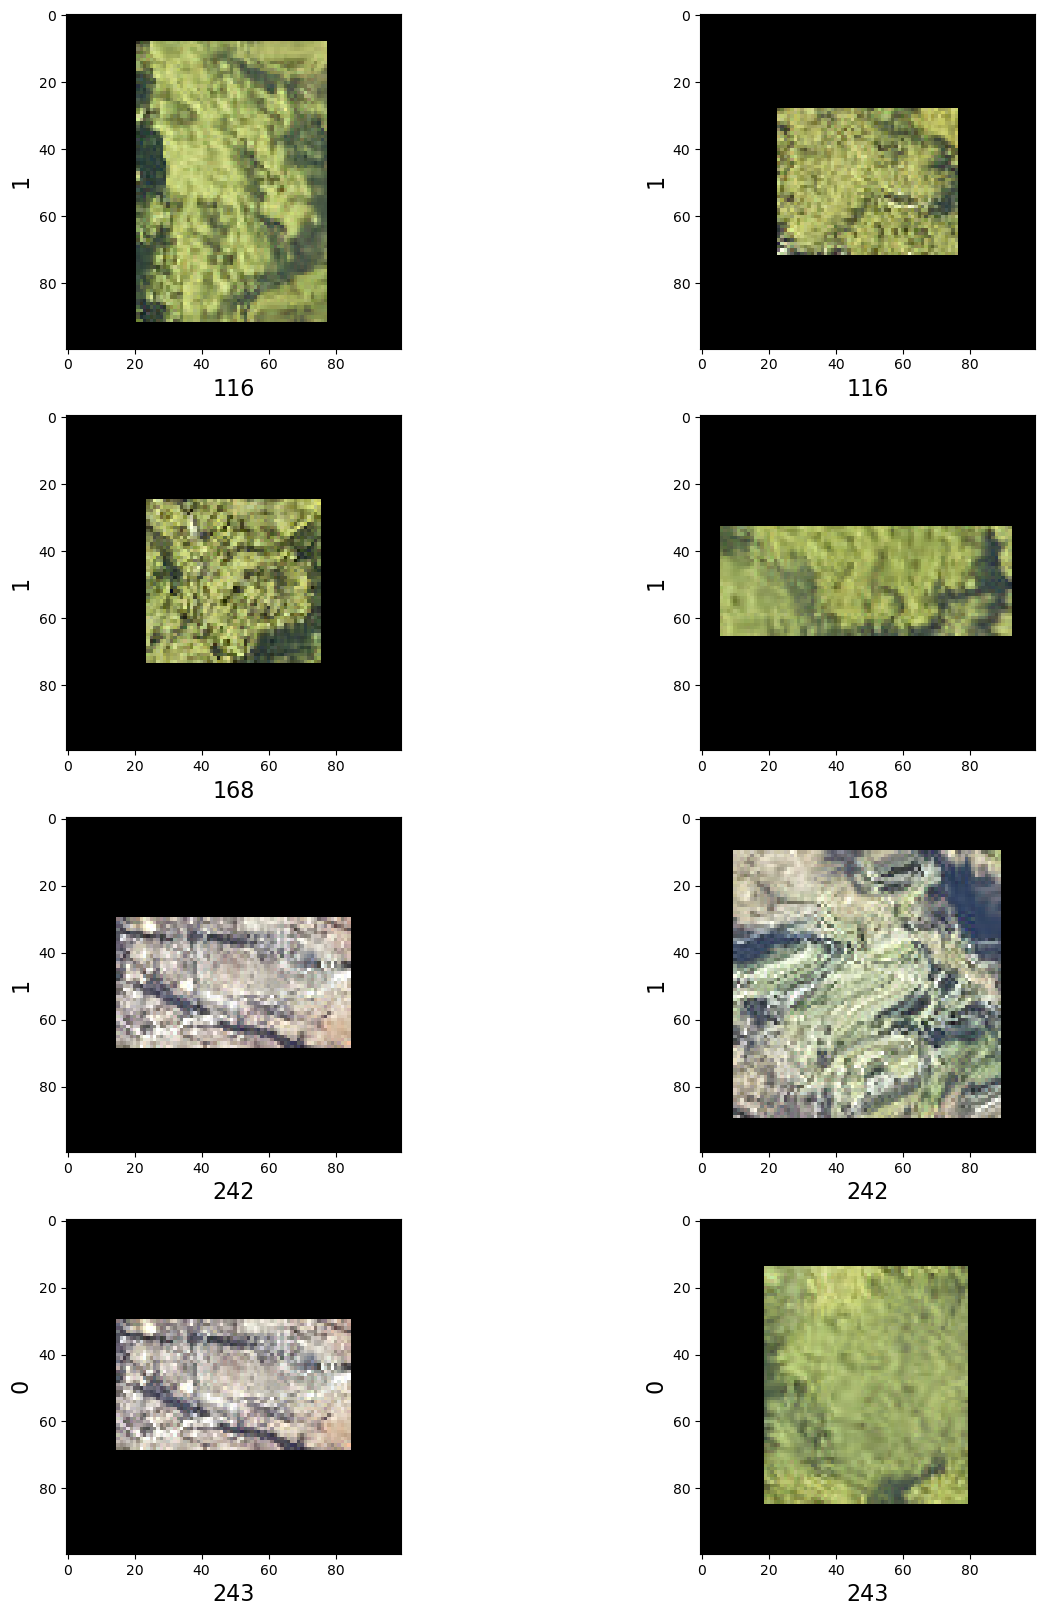

In [14]:
fig = plt.figure(figsize=(15, 20))
j = 0
for i in range(4):
    # idx = np.random.randint(6624)
    sub = fig.add_subplot(4, 2, j + 1)
    j = j+1
    idx = np.random.randint(images_pair.shape[0])
    sub.imshow(images_pair[idx,0,:,:,:].transpose(1,2,0).astype('int'))
    sub.set_ylabel(labels_pair[idx], fontsize=16)
    sub.set_xlabel(idx, fontsize=16)
    sub = fig.add_subplot(4, 2, j + 1)
    j = j+1
    sub.imshow(images_pair[idx,1,:,:,:].transpose(1,2,0).astype('int'))
    sub.set_ylabel(labels_pair[idx], fontsize=16)
    sub.set_xlabel(idx, fontsize=16)

plt.show(block=True)

# Run the model training

In [30]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=5)

In [31]:
history = model.fit([images_pair[:, 0], images_pair[:, 1]], labels_pair[:], validation_split=0.2, batch_size=32, epochs=50, callbacks=callbacks)

Epoch 1/50
7/7 [==============================] - 28s 4s/step - loss: 0.7232 - binary_accuracy: 0.5423 - val_loss: 0.7044 - val_binary_accuracy: 0.5686
Epoch 2/50
7/7 [==============================] - 25s 4s/step - loss: 0.6944 - binary_accuracy: 0.5373 - val_loss: 0.7039 - val_binary_accuracy: 0.4706
Epoch 3/50
7/7 [==============================] - 24s 4s/step - loss: 0.6844 - binary_accuracy: 0.5473 - val_loss: 0.7061 - val_binary_accuracy: 0.5686
Epoch 4/50
7/7 [==============================] - 25s 4s/step - loss: 0.6690 - binary_accuracy: 0.5871 - val_loss: 0.7787 - val_binary_accuracy: 0.5882
Epoch 5/50
7/7 [==============================] - 21s 3s/step - loss: 0.6483 - binary_accuracy: 0.6318 - val_loss: 0.7179 - val_binary_accuracy: 0.5490
Epoch 6/50
7/7 [==============================] - 21s 3s/step - loss: 0.6479 - binary_accuracy: 0.6816 - val_loss: 0.7328 - val_binary_accuracy: 0.5686
Epoch 7/50
7/7 [==============================] - 22s 3s/step - loss: 0.6312 - binary_ac

In [32]:
labels_pred = model.predict([images_pair[:, 0], images_pair[:, 1]])

8/8 [==============================] - 20s 3s/step


In [21]:
labels_pair

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

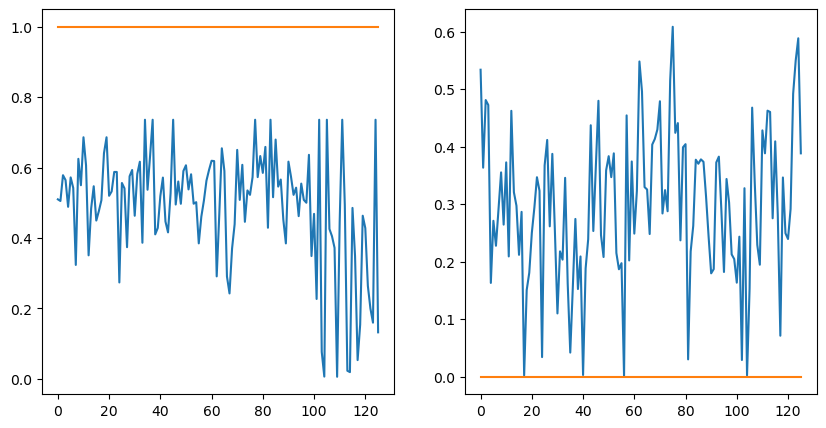

In [44]:
fig = plt.figure(figsize=(10, 5))

sub = fig.add_subplot(1, 2, 1)
sub.plot(labels_pred[::2])
sub.plot(labels_pair[::2])

sub = fig.add_subplot(1, 2, 2)
sub.plot(labels_pred[1::2])
sub.plot(labels_pair[1::2])
